In [1]:
# Autoload when refreshing notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import h5py
from scipy.io import loadmat
import pandas as pd
import re
import matplotlib.pyplot as plt
from types import SimpleNamespace
import scipy
import warnings
from scipy.ndimage import median_filter, gaussian_filter
from scipy.optimize import curve_fit

# import Python functions 
import sys
sys.path.append('../../')

from Python_Functions.functions import matstruct_to_dict, extractDAQBSAScalars, apply_tcav_zeroing_filter
from Python_Functions.gmm import biGaussian_image_from_flattened_params, flatten_biGaussian_params, unflatten_biGaussian_params

### MLP 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pickle
import numpy as np
from scipy.io import loadmat 
import re
import os 
import joblib
# Assumed: commonIndexFromSteps, extractDAQBSAScalars, and other helper functions are available

# ----------------------------------------------------------------------
# 0. Load the model with joblib
# Ex: MLP_LPS_GMM_E338_12710_20251031_194740


joblib_file = '../../model/LPS/MLP_LPS_GMM_E338_12710_20251101_113406.pkl'  # Modify as needed
model = joblib.load(joblib_file)
iz_scaler = pickle.load(open('../../model/LPS/E338_12710_iz_scaler_GMM_20251101_113406.pkl', 'rb'))
# ----------------------------------------------------------------------
# 1. Define the list of (experiment, runname, step_identifier) pairs to test the model on.
# ----------------------------------------------------------------------
run_pairs = [
    ('E338', '12716', 1),  # Example pairs, modify this list
    #('E300', '12431', 1),
    # Add more pairs here...
]

# ----------------------------------------------------------------------
# 2. Initialize lists for concatenation
# ----------------------------------------------------------------------
all_predictors = []
all_indices = []

print("Starting multi-run data loading and concatenation...")

# ----------------------------------------------------------------------
# 3. Loop through runs, load data, and concatenate
# ----------------------------------------------------------------------
for experiment, runname, step_id in run_pairs:
        
    # --- B. Load and Filter Predictor Data (BSA Scalars) ---
    
    # 1. Load data_struct
    dataloc = f'../../data/raw/{experiment}/{experiment}_{runname}/{experiment}_{runname}.mat'
    try:
        mat = loadmat(dataloc,struct_as_record=False, squeeze_me=True)
        data_struct = mat['data_struct']
    except FileNotFoundError:
        print(f"Skipping {experiment}_{runname}: .mat file not found at {dataloc}")
        continue

    # 2. Extract full BSA scalars (filtered by step_list if needed)
    # Don't filter by common index here, we'll do it with the goodShots scalar common index loaded from the file
    bsaScalarData, bsaVars = extractDAQBSAScalars(data_struct, filter_index=False)
    bsaScalarData = apply_tcav_zeroing_filter(bsaScalarData, bsaVars)

    ampl_idx = next(i for i, var in enumerate(bsaVars) if 'TCAV_LI20_2400_A' in var)
    xtcavAmpl = bsaScalarData[ampl_idx, :]

    phase_idx = next(i for i, var in enumerate(bsaVars) if 'TCAV_LI20_2400_P' in var)
    xtcavPhase = bsaScalarData[phase_idx, :]
    xtcavOffShots = xtcavAmpl<0.1
    xtcavPhase[xtcavOffShots] = 0 #Set this for ease of plotting

    # 3. 

    # 5. Filter BSA data using the final index
    # goodShots_scal_common_index is 1 based indexing from MATLAB, convert to 0 based
    bsaScalarData_filtered = bsaScalarData
    
    # 6. Construct the predictor array
    predictor_current = np.vstack(bsaScalarData_filtered).T
    
    # C. Append to master lists
    all_predictors.append(predictor_current)
    
# ----------------------------------------------------------------------
# 4. Concatenate and finalize arrays
# ----------------------------------------------------------------------
# Combine all data arrays from the runs
predictor_tmp = np.concatenate(all_predictors, axis=0)

# Set image half dimensions (should match preprocessing)
yrange = 100
xrange = 100
NCOMP = 10  # Number of GMM parameters
print("\n--- Final Concatenated Data Shapes ---")
print(f"Total Predictors (predictor): {predictor_tmp.shape}")



Starting multi-run data loading and concatenation...
Applying filter: Setting 3257 samples of TCAV_LI20_2400_P to 0 where TCAV_LI20_2400_A < 1.0

--- Final Concatenated Data Shapes ---
Total Predictors (predictor): (3257, 130)


### Exclude BSA Variables

In [ ]:
from Python_Functions.functions import exclude_bsa_vars
excluded_var_idx = exclude_bsa_vars(bsaVars)
predictor_tmp_cleaned = np.delete(predictor_tmp, excluded_var_idx, axis=1)
print(f"Predictor shape after excluding variables: {predictor_tmp_cleaned.shape}")


Excluding BSA Variables: ['TCAV_LI20_2400_A', 'TCAV_LI20_2400_P', 'TORO_LI20_3255_TMIT', 'BPMS_LI20_3218_X', 'BPMS_LI20_3218_Y', 'BPMS_LI20_3218_TMIT', 'BPMS_LI20_3265_X', 'BPMS_LI20_3265_Y', 'BPMS_LI20_3265_TMIT', 'BPMS_LI20_3315_X', 'BPMS_LI20_3315_Y', 'BPMS_LI20_3315_TMIT', 'PMT_LI20_3350_QDCRAW', 'PMT_LI20_3360_QDCRAW']
Excluded variable indices: [105, 112, 113, 114, 115, 116, 117, 118, 119, 120, 124, 125, 126, 127]
Predictor shape after excluding variables: (3257, 116)


### Calibration

In [4]:
# Define XTCAV calibration
krf = 239.26
cal = 1167 # um/deg  http://physics-elog.slac.stanford.edu/facetelog/show.jsp?dir=/2025/11/13.03&pos=2025-$
streakFromGUI = cal*krf*180/np.pi*1e-6#um/um
xtcalibrationfactor = 6.35e-15

isChargePV = [bool(re.search(r'TORO_LI20_2452_TMIT', pv)) for pv in bsaVars]
if isChargePV:
    # Extract charge data
    pvidx = [i for i, val in enumerate(isChargePV) if val]
    charge = bsaScalarData[pvidx, :][0] * 1.6e-19  # in C 
    charge_filtered = charge

# Set flag for current profile fitting. If True, the current profile will be used to refine the GMM fit.
do_current_profile = True
NCOMP = 10

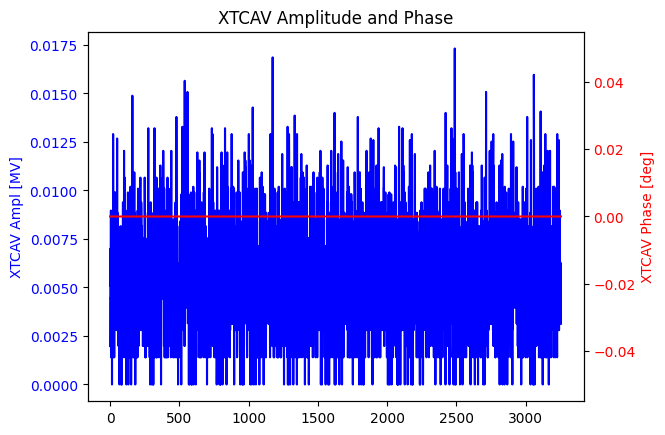

In [5]:

fig, ax1 = plt.subplots()
ax1.plot(xtcavAmpl, label='Amplitude', color='b')
ax1.set_ylabel('XTCAV Ampl [MV]', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(xtcavPhase, label='Phase', color='r')
ax2.set_ylabel('XTCAV Phase [deg]', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('XTCAV Amplitude and Phase')
plt.show()

In [6]:
    
# --- Original scaling and splitting logic follows ---

x_scaler = MinMaxScaler()
x_scaled = x_scaler.fit_transform(predictor_tmp_cleaned)

# all dataset is used for testing purpose here
x_test_scaled = x_scaled
ntest = np.arange(x_test_scaled.shape[0])

# Convert to PyTorch tensors
X_test = torch.tensor(x_test_scaled, dtype=torch.float32)
# Evaluate model
model.eval()
with torch.no_grad():
    pred_test_scaled = model(X_test).numpy()

# Inverse transform predictions
pred_test_full = iz_scaler.inverse_transform(pred_test_scaled)
#pca.inverse_transform(pred_test_scaled)
# Compute R² score
def r2_score(true, pred):
    RSS = np.sum((true - pred)**2)
    TSS = np.sum((true - np.mean(true))**2)
    return 1 - RSS / TSS if TSS != 0 else s0

print("Test R² is Unknown (Iz_test_true not available)")


Test R² is Unknown (Iz_test_true not available)


### Plot prediction

In [15]:
from ipywidgets import interact, IntSlider, Layout
def plot_xtcav_image_pred(idx):
    fig, (ax2, cx1) = plt.subplots(1,2,figsize=(8, 6), gridspec_kw={'width_ratios': [1, 0.02]})
    pred_params = pred_test_full.T.reshape(NCOMP,pred_test_full.shape[0])[:,idx]
    pred_im = biGaussian_image_from_flattened_params(pred_params)
    im2 = ax2.imshow(pred_im, cmap = "jet",aspect='auto',vmin=0,vmax= 1)
    ax2.set(xlabel = "Time [fs]")
    ax2.set(ylabel = "y [pix]")
    ax2.set(title = f"LPS Prediction: {experiment}_{runname}, Shot Number: {ntest[idx]}")
    ax2.set(xlim = (0,2*xrange))
    ax2.set(ylim= (0,2*yrange))
    cbar = fig.colorbar(im2, cax=cx1, fraction=0.16, pad=0.04)
    # cbar.set_label("Current [arb. units]")
    plt.subplots_adjust(wspace=0.4)
    # plt.tight_layout()
    # fig.show()
    # Also plot R² value for this index
    print(f"Displaying prediction for index: {idx}")
    print(f"Parameters: {unflatten_biGaussian_params(pred_params)}")

# Create slider
interact(plot_xtcav_image_pred, idx=IntSlider(min=0, max=pred_test_full.shape[0]-1, step=1, value=0, layout=Layout(width='1000px')))

interactive(children=(IntSlider(value=0, description='idx', layout=Layout(width='1000px'), max=3256), Output()…

<function __main__.plot_xtcav_image_pred(idx)>

In [8]:
from ipywidgets import interact, IntSlider
def plot_xtcav_image_pred_current(idx):
    FACTOR = 1e15
    peak_index = 0
    fig, (ax0) = plt.subplots(1,1,figsize=(10, 6))
    pred_params = pred_test_full.T.reshape(NCOMP,pred_test_full.shape[0])[:,idx]
    # Current profile is relative to zeta; transpose so that the drive bunch center agrees with the fit.
    pred_params_uf = unflatten_biGaussian_params(pred_params)
    pred_params = flatten_biGaussian_params(pred_params_uf)
    
    if isChargePV:
        # Normalize predicted image so that its integral matches the charge
        charge_value = charge_filtered[ntest[idx]]
        pred_im = biGaussian_image_from_flattened_params(pred_params, charge_value)
    else:
        pred_im = biGaussian_image_from_flattened_params(pred_params)
         
    pred_im_proj = np.sum(pred_im, axis = 0) * FACTOR
    x_grid = np.linspace(0, 2*xrange * xtcalibrationfactor * FACTOR, num=pred_im_proj.shape[0])
    ax0.plot(x_grid+(peak_index-xrange) * xtcalibrationfactor * FACTOR, pred_im_proj, label = "prediction")
    # Fix x-axis limits
    ax0.set(xlim = (-xrange * xtcalibrationfactor * FACTOR, xrange * xtcalibrationfactor * FACTOR))
    ax0.legend()
    ax0.set(title = f"Prediction of Current Profile: {experiment}_{runname}, Shot Number: {ntest[idx]}")
    ax0.set(xlabel = "Time [fs]")
    ax0.set(ylabel = "Current [A]")

    print("Predicted Gaussian Parameters:")
    pred_ug = unflatten_biGaussian_params(pred_params)
    print("Means (Mu):", pred_ug['mu'].numpy())
    print("Covariances (Sigma):", pred_ug['Sigma'].numpy())
    print("Weights (Pi):", pred_ug['pi'].numpy())
    # cbar.set_label("Current [arb. units]")
    plt.subplots_adjust(wspace=0.4)
    # plt.tight_layout()
    # fig.show()
    # Also plot R² value for this index

    # Display image_to_bigaussian_params debug info
    #biGaussianTest = image_to_bigaussian_params(images[valid_rows][ntest[idx]].reshape((2*yrange, 2*xrange)), do_current_profile, debug=True)
    #print("Bi-Gaussian Parameters for Test Image:", biGaussianTest)
    

# Create slider
interact(plot_xtcav_image_pred_current, idx=IntSlider(min=0, max=pred_test_full.shape[0]-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='idx', max=3256), Output()), _dom_classes=('widget-intera…

<function __main__.plot_xtcav_image_pred_current(idx)>

### PCA of PV Scalars

Plotting BSA Scalars: TCAV_LI20_2400_P (index 127) and TCAV_LI20_2400_A (index 126)


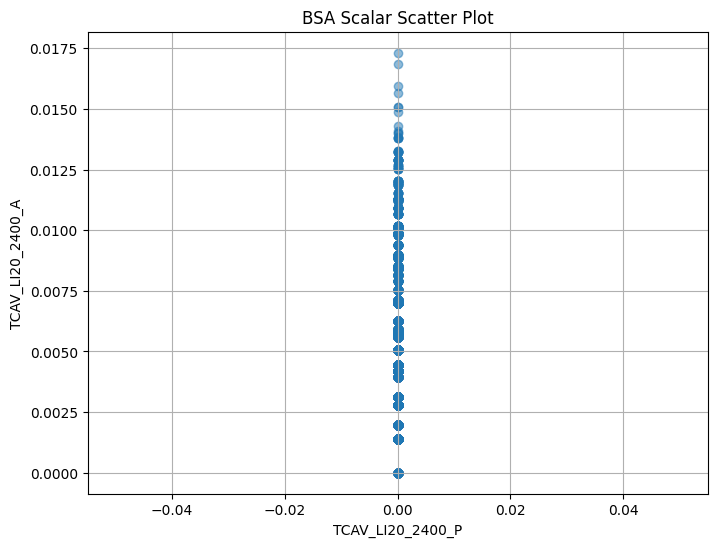

In [9]:
# plot bsaScalarData TCAV_LI20_2400_P and TCAV_LI20_2400_A, most important predictors.
bsaVarNames = bsaVars
var1_name = 'TCAV_LI20_2400_P'
var2_name = 'TCAV_LI20_2400_A'
var1_idx = bsaVarNames.index(var1_name)
var2_idx = bsaVarNames.index(var2_name)
print(f"Plotting BSA Scalars: {var1_name} (index {var1_idx}) and {var2_name} (index {var2_idx})")
plt.figure(figsize=(8,6))
plt.scatter(predictor_tmp[:, var1_idx], predictor_tmp[:, var2_idx], alpha=0.5)
plt.xlabel(var1_name)
plt.ylabel(var2_name)
plt.title('BSA Scalar Scatter Plot')
plt.grid(True)
plt.show()

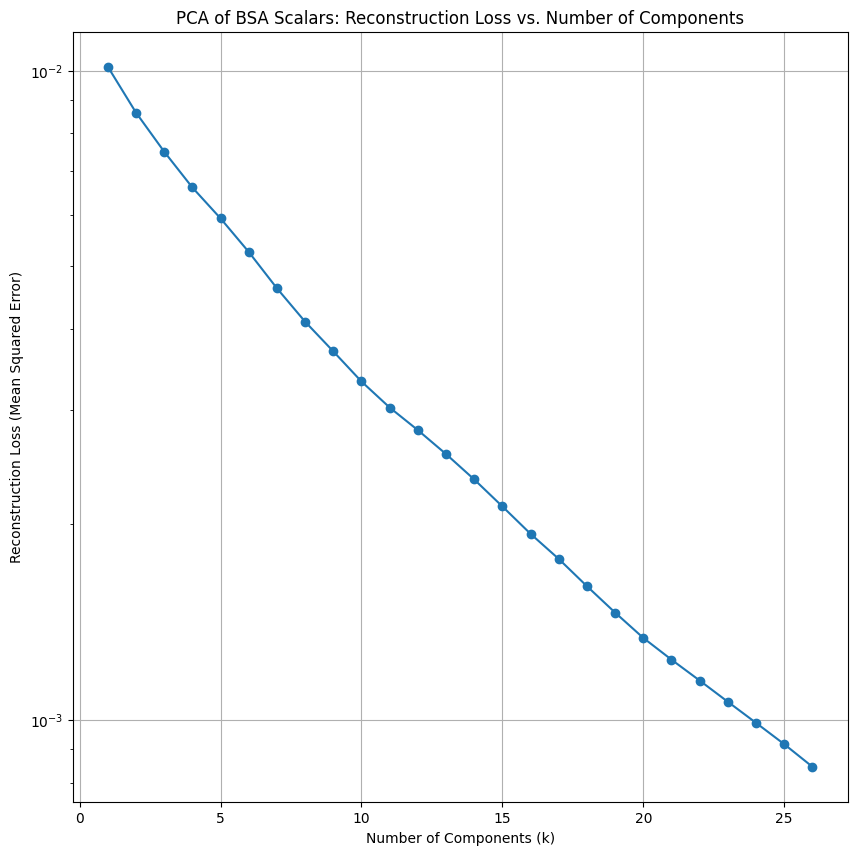

In [10]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Assuming bsaScalarData has shape (N_variables, N_samples) from your function
# Transpose the data so features are columns and samples are rows for scikit-learn PCA
X = bsaScalarData.T 

# Apply MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Determine the maximum number of components to test
# X.shape is (N_samples, N_variables). max_components = min(N_samples, N_variables) - 1 for a stable PCA
max_components = min(X.shape) // 5 

# Lists to store results
n_components_list = []
reconstruction_losses = []

# Loop through possible number of components
for k in range(1, max_components + 1):
    # 1. Initialize and fit PCA
    pca_study = PCA(n_components=k)
    pca_study.fit(X)
    
    # 2. Transform and Inverse Transform (Reconstruct)
    X_reduced = pca_study.transform(X)
    X_reconstructed = pca_study.inverse_transform(X_reduced)
    
    # 3. Calculate Reconstruction Loss (Mean Squared Error)
    loss = mean_squared_error(X, X_reconstructed)
    
    # Store results
    n_components_list.append(k)
    reconstruction_losses.append(loss)
    
# 4. Plot the Results
plt.figure(figsize=(10, 10))
plt.plot(n_components_list, reconstruction_losses, marker='o', linestyle='-')
plt.xlabel('Number of Components (k)')
plt.ylabel('Reconstruction Loss (Mean Squared Error)')
# Log scale in y-axis for better visualization
plt.yscale('log')
plt.title('PCA of BSA Scalars: Reconstruction Loss vs. Number of Components')
plt.grid(True)
# 5. Identify the "Elbow" point visually after plotting plt.show()
plt.show() 

# After plotting, the optimal number of components is the 'elbow' point.

In [11]:

num_components = 11

pca_comp_study = PCA(n_components=num_components)
pca_comp_study.fit(X)
# 1. Get explained variance and component loadings

variance_ratios = pca_comp_study.explained_variance_ratio_
loadings = pca_comp_study.components_

# 2. Create the DataFrame for component composition
# Each row in 'loadings' is a principal component (PC)
# Each column corresponds to a feature (PV)
df_loadings = pd.DataFrame(loadings, columns=bsaVars)

# 3. Add Component labels and Significance
component_labels = [f'PC {i+1}' for i in range(num_components)]
df_loadings.insert(0, 'Component', component_labels)
df_loadings.insert(1, 'Significance (Explained Variance Ratio)', variance_ratios)

# 4. Format the output
# The components are already ordered by significance (PC 1 is most significant)
# Format the significance column as a percentage for clarity
df_loadings['Significance (Explained Variance Ratio)'] = \
    df_loadings['Significance (Explained Variance Ratio)'].map(lambda x: f'{x:.4f} ({x*100:.2f}%)')

# Format the loadings to a fixed number of decimal places
for col in bsaVars:
    df_loadings[col] = df_loadings[col].map(lambda x: f'{x:.4f}')

# Display the resulting table
composition_table = df_loadings.to_markdown(index=False)
print("Composition of Principal Components:")
print(composition_table)

Composition of Principal Components:
| Component   | Significance (Explained Variance Ratio)   |   TORO_IN10_431_TMIT |   TORO_IN10_591_TMIT |   TORO_IN10_791_TMIT |   BPMS_IN10_221_X |   BPMS_IN10_221_Y |   BPMS_IN10_221_TMIT |   BPMS_IN10_371_X |   BPMS_IN10_371_Y |   BPMS_IN10_371_TMIT |   BPMS_IN10_425_X |   BPMS_IN10_425_Y |   BPMS_IN10_425_TMIT |   BPMS_IN10_511_X |   BPMS_IN10_511_Y |   BPMS_IN10_511_TMIT |   BPMS_IN10_525_X |   BPMS_IN10_525_Y |   BPMS_IN10_525_TMIT |   BPMS_IN10_581_X |   BPMS_IN10_581_Y |   BPMS_IN10_581_TMIT |   BPMS_IN10_631_X |   BPMS_IN10_631_Y |   BPMS_IN10_631_TMIT |   BPMS_IN10_651_X |   BPMS_IN10_651_Y |   BPMS_IN10_651_TMIT |   BPMS_IN10_731_X |   BPMS_IN10_731_Y |   BPMS_IN10_731_TMIT |   BPMS_IN10_771_X |   BPMS_IN10_771_Y |   BPMS_IN10_771_TMIT |   BLEN_IN10_596_BRAW |   BPMS_IN10_781_X |   BPMS_IN10_781_Y |   BPMS_IN10_781_TMIT |   PMTR_HT10_950_PWR |   LASR_LT10_930_PWR |   KLYS_LI10_21_FB_FAST_PACT |   KLYS_LI10_21_FB_FAST_AACT |   ACCL_LI10_21

In [12]:
# 1. Extract and Square the Loadings (Loadings matrix is: Components x Variables)
# loadings = pca_comp_study.components_ (from your provided code block)
squared_loadings = loadings**2

# 2. Sum Across Components (Sum columns to get total significance per variable)
# The result is an array where each element is the total squared loading for a variable
total_squared_loadings = np.sum(squared_loadings, axis=0)

# 3. Create a DataFrame for sorting
# bsaVars is the list of variable names (features)
df_var_significance = pd.DataFrame({
    'BSA Variable (PV)': bsaVars,
    'Total Squared Loading (Significance)': total_squared_loadings
})

# 4. Sort in descending order
df_var_significance = df_var_significance.sort_values(
    by='Total Squared Loading (Significance)', 
    ascending=False
).reset_index(drop=True)

# 5. Specify the number of top variables to display
N_top = 20  # Example: display the top few most significant variables

# 6. Format and display the table
df_top_vars = df_var_significance.head(N_top)
df_top_vars['Total Squared Loading (Significance)'] = \
    df_top_vars['Total Squared Loading (Significance)'].map(lambda x: f'{x:.4f}')

inverted_table = df_top_vars.to_markdown(index=False)
print(f"Top {N_top} BSA Variables Ordered by Significance in PCA Components:")
print(inverted_table)


Top 20 BSA Variables Ordered by Significance in PCA Components:
| BSA Variable (PV)    |   Total Squared Loading (Significance) |
|:---------------------|---------------------------------------:|
| BLEN_LI11_359_BRAW   |                                 0.9978 |
| BPMS_LI11_201_Y      |                                 0.8427 |
| PMT_LI20_3350_QDCRAW |                                 0.8121 |
| LASR_LT10_930_PWR    |                                 0.6223 |
| BPMS_LI20_3265_X     |                                 0.4614 |
| PMTR_HT10_950_PWR    |                                 0.367  |
| BPMS_IN10_371_X      |                                 0.2454 |
| BPMS_LI20_3315_Y     |                                 0.2178 |
| BPMS_LI11_132_X      |                                 0.2075 |
| BPMS_LI20_3265_Y     |                                 0.2042 |
| BPMS_IN10_631_Y      |                                 0.1919 |
| BPMS_LI11_393_Y      |                                 0.1907 |
| BPMS_LI11_

/tmp/ipykernel_36931/281879205.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_vars['Total Squared Loading (Significance)'] = \


In [13]:

df_filtered = df_var_significance[
    ~df_var_significance['BSA Variable (PV)'].str.contains('BPM', case=False, na=False)
]

# 5. Sort the filtered variables in descending order of significance
df_filtered = df_filtered.sort_values(
    by='Total Squared Loading (Significance)', 
    ascending=False
).reset_index(drop=True)

# 6. Select Top N and format
N_top = 20 # Display the top few most significant non-BPM variables
df_top_vars = df_filtered.head(N_top)

# Format the significance column
df_top_vars['Total Squared Loading (Significance)'] = \
    df_top_vars['Total Squared Loading (Significance)'].map(lambda x: f'{x:.4f}')

# Display the resulting table
inverted_table = df_top_vars.to_markdown(index=False)

print(f"Top {N_top} BSA Variables (EXCLUDING BPMS) Ordered by Significance in PCA Components:")
print(inverted_table)

Top 20 BSA Variables (EXCLUDING BPMS) Ordered by Significance in PCA Components:
| BSA Variable (PV)           |   Total Squared Loading (Significance) |
|:----------------------------|---------------------------------------:|
| BLEN_LI11_359_BRAW          |                                 0.9978 |
| PMT_LI20_3350_QDCRAW        |                                 0.8121 |
| LASR_LT10_930_PWR           |                                 0.6223 |
| PMTR_HT10_950_PWR           |                                 0.367  |
| TORO_LI20_3163_TMIT         |                                 0.106  |
| TORO_LI20_3255_TMIT         |                                 0.1029 |
| TORO_LI20_2452_TMIT         |                                 0.0819 |
| PMT_LI20_3070_QDCRAW        |                                 0.0551 |
| TORO_LI20_2040_TMIT         |                                 0.0214 |
| TORO_LI11_360_TMIT          |                                 0.021  |
| TORO_LI20_1988_TMIT         |            

/tmp/ipykernel_36931/2531780689.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_vars['Total Squared Loading (Significance)'] = \


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from ipywidgets import interact, IntSlider, FloatSlider, Layout
import torch

index_to_examine = 10  # Change this index to examine different test samples

# Variables to be controlled (Non-BPM variables from previous ranking logic)
CONTROL_VARS = [
    'BLEN_LI11_359_BRAW', 'TCAV_LI20_2400_A', 'TCAV_LI20_2400_P', 
    'LASR_LT10_930_PWR', 'PMTR_HT10_950_PWR', 'PMT_LI20_3350_QDCRAW', 
    'KLYS_LI10_41_FB_FAST_PACT', 'KLYS_LI10_41_FB_FAST_AACT'
]
# ==============================================================================
# --- DYNAMIC PREDICTION FUNCTION ---
# ==============================================================================
original_predictor_reconstructed = x_scaler.inverse_transform(X_test.numpy())
def plot_dynamic_pred(**slider_values):
    idx = index_to_examine
    fig, (ax1, ax2,ax3, cx1) = plt.subplots(1,4,figsize=(10, 3), gridspec_kw={'width_ratios': [1, 1,1, 0.02]})
    im1 = ax1.imshow(np.flip(Iz_test_true.T.reshape(2*yrange,2*xrange,Iz_test_true.shape[0])[:,:,idx], axis=0), cmap = "jet",aspect='auto', vmin = 0, vmax = 400)
   
    # ax1.suptitle(f"Current Profile Index: {idx}")
    ax1.set(ylabel="y [pix]")
    ax1.set(xlabel = "Time [fs]")
    ax1.set(title = f"True(Shot Number: {ntest[idx]})")
    ax1.set(xlim = (0,2*xrange))
    ax1.set(ylim= (0,2*yrange))

    im2 = ax2.imshow(np.flip(pred_test_full.T.reshape(2*yrange,2*xrange,Iz_test_true.shape[0])[:,:,idx], axis=0), cmap = "jet",aspect='auto',vmin = 0, vmax = 400)
    ax2.set(xlabel = "Time [fs]")
    ax2.set(ylabel = "y [pix]")
    ax2.set(title = "Prediction")
    ax2.set(xlim = (0,2*xrange))
    ax2.set(ylim= (0,2*yrange))

    # Modify the predictor for the given index based on slider values
    modified_predictor = original_predictor_reconstructed[idx].copy()
    for var_name, slider in slider_values.items():
        pv_index = bsaVarNames.index(var_name)
        modified_predictor[pv_index] = slider

    # Scale back the modified predictor
    modified_predictor_scaled = x_scaler.transform(modified_predictor.reshape(1, -1))

    # Make prediction with modified predictor
    modified_predictor_tensor = torch.tensor(modified_predictor_scaled, dtype=torch.float32)
    with torch.no_grad():
        modified_pred_scaled = model(modified_predictor_tensor).numpy()
    modified_pred_full = iz_scaler.inverse_transform(pca.inverse_transform(modified_pred_scaled))
    im3 = ax3.imshow(np.flip(modified_pred_full.T.reshape(2*yrange,2*xrange)[:,:], axis=0), cmap = "jet",aspect='auto',vmin = 0, vmax = 400)
    ax3.set(xlabel = "Time [fs]")
    ax3.set(ylabel = "y [pix]")
    ax3.set(title = "Modified Prediction")
    ax3.set(xlim = (0,2*xrange))
    ax3.set(ylim= (0,2*yrange))

    cbar = fig.colorbar(im1, cax=cx1, fraction=0.16, pad=0.04)
    # cbar.set_label("Current [arb. units]")
    plt.subplots_adjust(wspace=0.4)
    # plt.tight_layout()
    # fig.show()
    # Also plot R² value for this index
    r2_val = r2_score(Iz_test_true.T.reshape(2*yrange,2*xrange,Iz_test_true.shape[0])[:,:,idx], pred_test_full.T.reshape(2*yrange,2*xrange,Iz_test_true.shape[0])[:,:,idx])
    plt.suptitle(f'R² Value: {r2_val:.4f}', fontsize=7)

# ==============================================================================
# --- INTERACTIVE WIDGET SETUP ---
# ==============================================================================

# 1. Calculate min/max for sliders (using the mock raw data)
raw_min_max = {}
for i, pv_name in enumerate(CONTROL_VARS):
    pv_index = bsaVarNames.index(pv_name)
    raw_min_max[pv_name] = (predictor_tmp[:, pv_index].min(), predictor_tmp[:, pv_index].max())

N_SAMPLES = Iz_test_true.shape[0]

# 2. Setup the Widgets
widget_kwargs = {}  # Fixed index for demonstration

for i, pv_name in enumerate(CONTROL_VARS):
    min_val, max_val = raw_min_max[pv_name]
    pv_index = bsaVarNames.index(pv_name)
    # Initial value is the mean of the range, as we cannot predict 
    # the X_test[idx] value without dynamic input in the slider setup.
    # We set it to 0.0 (or mid-range) and rely on the plot_dynamic_pred 
    # function to construct the input correctly.
    initial_value = original_predictor_reconstructed[index_to_examine, pv_index] # Use the value for the initial index (idx=0)
    
    widget_kwargs[pv_name] = FloatSlider(
        min=min_val, 
        max=max_val, 
        step=(max_val - min_val) / 100.0, # 100 steps granularity
        value=initial_value,
        description=pv_name,
        readout_format='.4f',
        layout=Layout(width='90%')
    )

print("--- Dynamic ML Prediction Explorer ---")
print("Adjust the sliders below to see the real-time effect on the LPS profile prediction.")

# 3. Create the Interactive Interface
# Note: The widget values are passed as keyword arguments to plot_dynamic_pred
interact(plot_dynamic_pred, **widget_kwargs)


NameError: name 'Iz_test_true' is not defined